In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [6]:
seed=42

In [7]:
INFILE = './processed/glucose_stats.csv'

In [8]:
glucose_stats_df = pd.read_csv(INFILE)

In [9]:
glucose_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18371 entries, 0 to 18370
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   INDEX                            18371 non-null  int64  
 1   CURRENT_VALUE                    18371 non-null  int64  
 2   LAST_VALUE                       18371 non-null  int64  
 3   SLOPE                            18371 non-null  float64
 4   R_SQUARED                        18371 non-null  float64
 5   SLOPE_SECOND_HALF                18371 non-null  object 
 6   C0                               18371 non-null  float64
 7   C1                               18371 non-null  float64
 8   C2                               18371 non-null  float64
 9   GLUCOSE_MEAN                     18371 non-null  float64
 10  GLUCOSE_MEDIAN                   18371 non-null  float64
 11  MEAN_TO_MEDIAN                   18371 non-null  float64
 12  GLUCOSE_STDDEV    

In [35]:
glucose_stats_df.head()

,INDEX,CURRENT_VALUE,LAST_VALUE,SLOPE,SLOPE_SECOND_HALF,C0,C1,C2,GLUCOSE_MEAN,GLUCOSE_MEDIAN,...,GRADIENT_MIN,GRADIENT_MIN_GLUCOSE,GRADIENT_MIN_MINUTE,CURVATURE_MIN,CURVATURE_MIN_GLUCOSE,CURVATURE_MIN_MINUTE,EXTRAPOLATED_VALUE_FIRST_ORDER,EXTRAPOLATED_VALUE_SECOND_ORDER,IS_LOW,LOOK_AHEAD_VALUE
0,10,0.123596,0.163142,0.665261,0.471014,0.427286,0.698578,0.128360,0.143796,0.181548,...,0.740157,0.193732,0.8,0.729167,0.191011,0.6,129.83,99.08,0,88
1,14,0.191011,0.117825,0.485666,0.427536,0.506747,0.550608,0.207312,0.139769,0.165179,...,0.598425,0.185185,0.4,0.729167,0.193820,0.2,69.72,64.84,0,95
2,18,0.134831,0.148036,0.606239,0.507246,0.550225,0.594584,0.143577,0.119063,0.141369,...,0.716535,0.136752,0.0,0.833333,0.160112,1.0,102.33,111.61,0,95
3,22,0.154494,0.123867,0.564081,0.427536,0.455772,0.624439,0.164427,0.134199,0.157738,...,0.692913,0.165242,0.6,0.791667,0.168539,0.4,93.50,72.03,0,95
4,26,0.154494,0.111782,0.567454,0.471014,0.544228,0.576075,0.163340,0.124118,0.147321,...,0.685039,0.148148,1.0,0.763889,0.146067,1.0,91.43,98.75,0,85


In [88]:
glucose_stats_df['IS_LOW'].value_counts()

0    17869
1      502
Name: IS_LOW, dtype: int64

In [173]:
# Classes are imbalanced, so we'll need to Under/Oversample

# Analysis of Extrapolated Methods

## First Order Fit

### Confusion Matrix Numbers

In [268]:
true_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['EXTRAPOLATED_VALUE_FIRST_ORDER'] < 70) ]
true_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['EXTRAPOLATED_VALUE_FIRST_ORDER'] > 70) ]
false_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['EXTRAPOLATED_VALUE_FIRST_ORDER'] < 70) ]
false_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['EXTRAPOLATED_VALUE_FIRST_ORDER'] > 70) ]

print('# True Positives: {}'.format(true_positive.shape[0]))
print('# True Negatives: {}'.format(true_negative.shape[0]))
print('# False Positives: {}'.format(false_positive.shape[0]))
print('# False Negatives: {}'.format(false_negative.shape[0]))

# True Positives: 266
# True Negatives: 17183
# False Positives: 686
# False Negatives: 236


This method has poor low-prediction accuracy: 266 / (266 + 236) ~ 53%

### Plot predicted glucose vs. real glucose

The distribution of the incorrect predicted glucose values are highest near the low threshold (70). This means the method *almost* predicted correctly.  

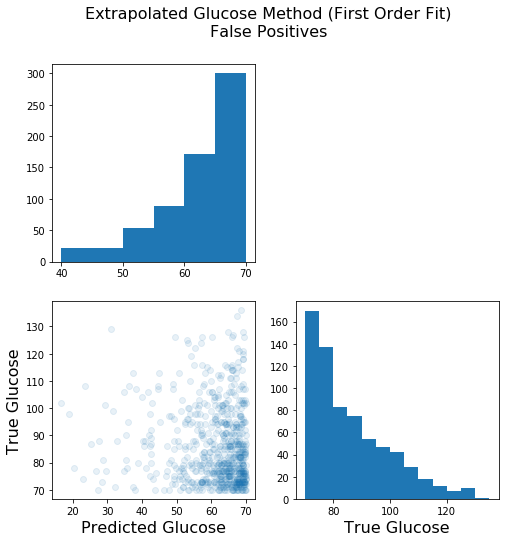

In [269]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

fig.suptitle('Extrapolated Glucose Method (First Order Fit)\nFalse Positives', fontsize=16)

axes[0][0].hist(false_positive['EXTRAPOLATED_VALUE_FIRST_ORDER'].values, bins=[40,45,50,55,60,65,70])

axes[1][1].hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135])
axes[1][1].set_xlabel('True Glucose', fontsize=16)

axes[1][0].scatter(false_positive['EXTRAPOLATED_VALUE_FIRST_ORDER'].values, false_positive['LOOK_AHEAD_VALUE'].values, alpha=0.1)
axes[1][0].set_ylabel('True Glucose', fontsize=16)
axes[1][0].set_xlabel('Predicted Glucose', fontsize=16)

axes[0][1].set_axis_off()

236


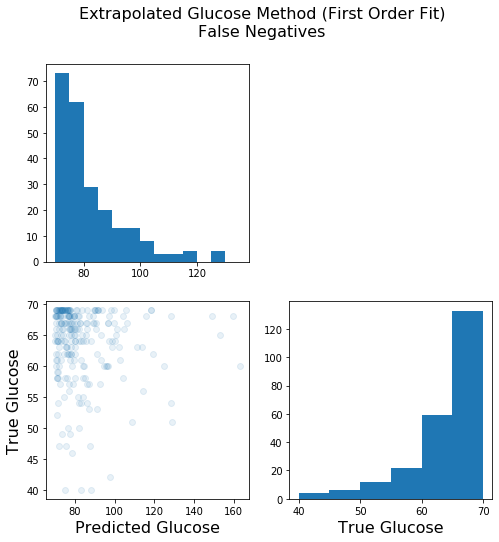

In [270]:
import seaborn as sns

print(false_negative.shape[0])
fig, axes = plt.subplots(2, 2, figsize=(8,8))

fig.suptitle('Extrapolated Glucose Method (First Order Fit)\nFalse Negatives', fontsize=16)

axes[0][0].hist(false_negative['EXTRAPOLATED_VALUE_FIRST_ORDER'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135])

axes[1][1].hist(false_negative['LOOK_AHEAD_VALUE'].values, bins=[40,45,50,55,60,65,70])
axes[1][1].set_xlabel('True Glucose', fontsize=16)

axes[1][0].scatter(false_negative['EXTRAPOLATED_VALUE_FIRST_ORDER'].values, false_negative['LOOK_AHEAD_VALUE'].values, alpha=0.1)
axes[1][0].set_ylabel('True Glucose', fontsize=16)
axes[1][0].set_xlabel('Predicted Glucose', fontsize=16)

axes[0][1].set_axis_off()

## Second Order Fit

In [271]:
true_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['EXTRAPOLATED_VALUE_SECOND_ORDER'] < 70) ]
true_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['EXTRAPOLATED_VALUE_SECOND_ORDER'] > 70) ]
false_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['EXTRAPOLATED_VALUE_SECOND_ORDER'] < 70) ]
false_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['EXTRAPOLATED_VALUE_SECOND_ORDER'] > 70) ]

print('# True Positives: {}'.format(true_positive.shape[0]))
print('# True Negatives: {}'.format(true_negative.shape[0]))
print('# False Positives: {}'.format(false_positive.shape[0]))
print('# False Negatives: {}'.format(false_negative.shape[0]))

# True Positives: 294
# True Negatives: 16779
# False Positives: 1090
# False Negatives: 208


The higher order fit predicts lows more accurately, but has more false positives

### Plot predicted glucose vs. real glucose

The distribution of the incorrect predicted glucose values are highest near the low threshold (70). This means the method *almost* predicted correctly.  

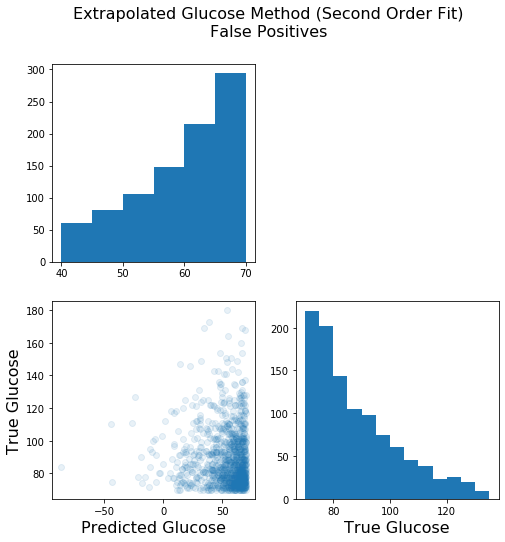

In [272]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

fig.suptitle('Extrapolated Glucose Method (Second Order Fit)\nFalse Positives', fontsize=16)

axes[0][0].hist(false_positive['EXTRAPOLATED_VALUE_SECOND_ORDER'].values, bins=[40,45,50,55,60,65,70])

axes[1][1].hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135])
axes[1][1].set_xlabel('True Glucose', fontsize=16)

axes[1][0].scatter(false_positive['EXTRAPOLATED_VALUE_SECOND_ORDER'].values, false_positive['LOOK_AHEAD_VALUE'].values, alpha=0.1)
axes[1][0].set_ylabel('True Glucose', fontsize=16)
axes[1][0].set_xlabel('Predicted Glucose', fontsize=16)

axes[0][1].set_axis_off()

208


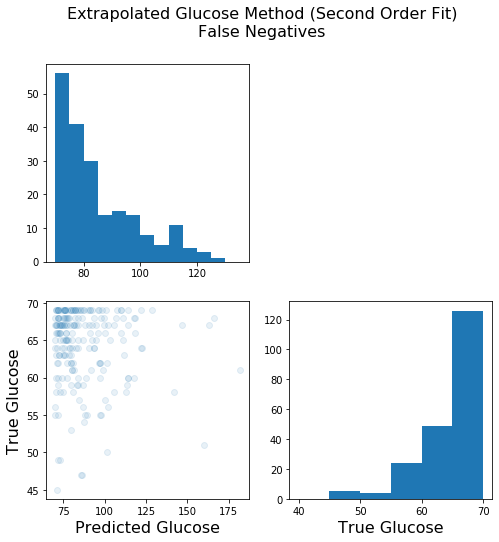

In [273]:
import seaborn as sns

print(false_negative.shape[0])
fig, axes = plt.subplots(2, 2, figsize=(8,8))

fig.suptitle('Extrapolated Glucose Method (Second Order Fit)\nFalse Negatives', fontsize=16)

axes[0][0].hist(false_negative['EXTRAPOLATED_VALUE_SECOND_ORDER'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135])

axes[1][1].hist(false_negative['LOOK_AHEAD_VALUE'].values, bins=[40,45,50,55,60,65,70])
axes[1][1].set_xlabel('True Glucose', fontsize=16)

axes[1][0].scatter(false_negative['EXTRAPOLATED_VALUE_SECOND_ORDER'].values, false_negative['LOOK_AHEAD_VALUE'].values, alpha=0.1)
axes[1][0].set_ylabel('True Glucose', fontsize=16)
axes[1][0].set_xlabel('Predicted Glucose', fontsize=16)

axes[0][1].set_axis_off()

## Example Plots

In [10]:
INFILE = './processed/glucose.csv'

In [11]:
glucose_df = pd.read_csv(INFILE)

In [12]:
glucose_df.head()

,Timestamp,Glucose,Time_Diff
0,2020-11-09 11:07:34,146,5.0
1,2020-11-09 11:12:34,147,5.0
2,2020-11-09 11:17:33,135,5.0
3,2020-11-09 11:22:33,120,5.0
4,2020-11-09 11:27:33,103,5.0


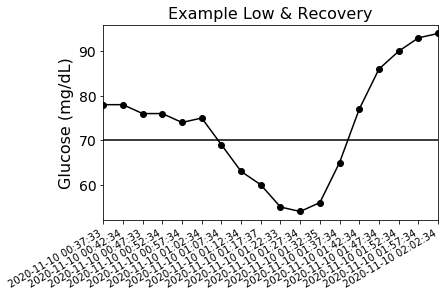

In [38]:
INDEX = 155
NUM_POINTS = 18

example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values

fig, ax = plt.subplots()

ax.plot(example_dates, example_values, marker='o', color='k')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='minor', labelsize=0)

ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.set_title('Example Low & Recovery', fontsize=16)

fig.autofmt_xdate()


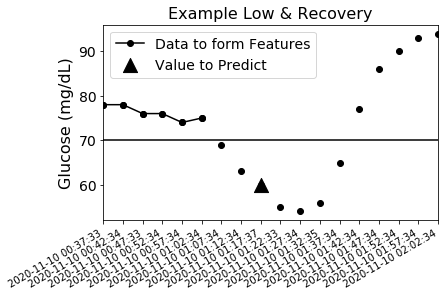

In [47]:
INDEX = 155
NUM_POINTS = 18

example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values

fig, ax = plt.subplots()

ax.scatter(example_dates, example_values, facecolor='k')
ax.plot(example_dates[:6], example_values[:6], marker='o', color='k', label='Data to form Features')
ax.scatter(example_dates[8], example_values[8], marker='^', color='k', s=200, label='Value to Predict')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='minor', labelsize=0)
ax.legend(fontsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.set_title('Example Low & Recovery', fontsize=16)

fig.autofmt_xdate()

In [13]:
def get_extrapolated_values(x, y, to_low=3, deg=1, npts=1, time_delta=5):

    coeffs = np.polyfit(x[:-to_low] * time_delta, y[:-to_low], deg)

    values = []
    for xi in x:
        value = 0
        for i, c in enumerate(coeffs):
            
            value += c * (xi * time_delta) ** (deg - i)
    
        values.append(value)
    return values


In [127]:
INDEX = 206
NUM_POINTS = 12
NUM_DATA = 6
TO_LOW = 3



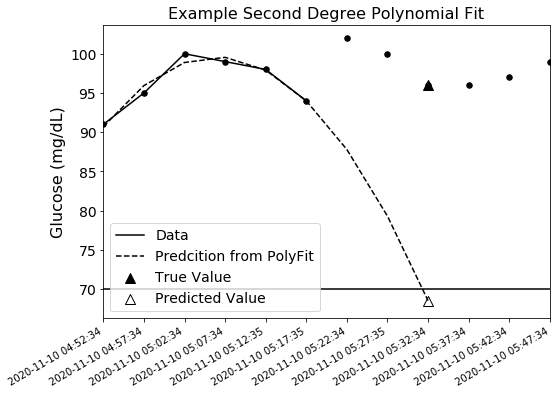

In [128]:
import matplotlib.dates as mdates
import matplotlib.ticker



example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values
predicted_value = glucose_stats_df.loc[glucose_stats_df['INDEX'] == INDEX]['EXTRAPOLATED_VALUE_SECOND_ORDER']

prediction = get_extrapolated_values(np.arange(NUM_DATA+TO_LOW), example_values[:NUM_DATA+TO_LOW], deg=2)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(example_dates, example_values, color='k', s=30)
ax.plot(example_dates[:NUM_DATA], example_values[:NUM_DATA], color='k', ls='-', label='Data')

ax.plot(example_dates[:NUM_DATA+TO_LOW], prediction, 'k--', label='Predcition from PolyFit')

ax.scatter(example_dates[NUM_DATA+TO_LOW-1], example_values[NUM_DATA+TO_LOW-1], marker='^', facecolor='k', s=100, label='True Value')
ax.scatter(example_dates[NUM_DATA+TO_LOW-1], predicted_value, marker='^', facecolor='w', edgecolor='k', s=100, label='Predicted Value')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Example Second Degree Polynomial Fit', fontsize=16)
fig.autofmt_xdate()


In [347]:
INDEX = 155

[78.39285714285717, 77.26428571428575, 76.31428571428575, 75.54285714285717, 74.95000000000005, 74.53571428571432, 74.30000000000004, 74.24285714285719, 74.36428571428576]


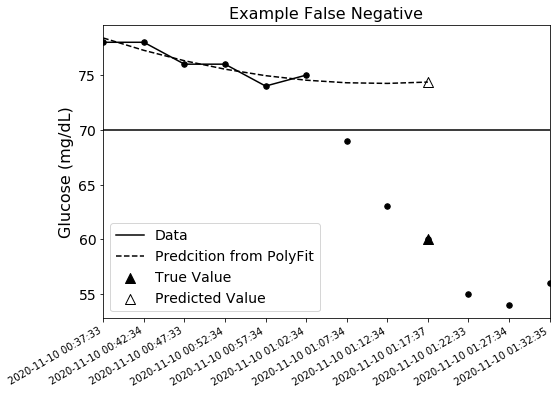

In [348]:
import matplotlib.dates as mdates
import matplotlib.ticker


example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values
predicted_value = glucose_stats_df.loc[glucose_stats_df['INDEX'] == INDEX]['EXTRAPOLATED_VALUE_SECOND_ORDER']

prediction = get_extrapolated_values(np.arange(NUM_DATA+TO_LOW), example_values[:NUM_DATA+TO_LOW], deg=2)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(example_dates, example_values, color='k', s=30)
ax.plot(example_dates[:NUM_DATA], example_values[:NUM_DATA], color='k', ls='-', label='Data')

ax.plot(example_dates[:NUM_DATA+TO_LOW], prediction, 'k--', label='Predcition from PolyFit')


ax.scatter(example_dates[NUM_DATA+TO_LOW-1], example_values[NUM_DATA+TO_LOW-1], marker='^', facecolor='k', s=100, label='True Value')
ax.scatter(example_dates[NUM_DATA+TO_LOW-1], predicted_value, marker='^', facecolor='w', edgecolor='k', s=100, label='Predicted Value')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Example False Negative', fontsize=16)
fig.autofmt_xdate()


# Logistic Regression

## Balanced Class Weights

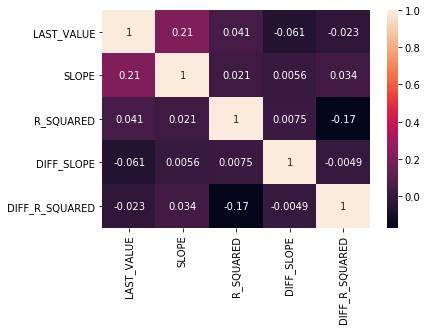

In [132]:
import seaborn as sns

FEATURE_COLS = ['LAST_VALUE',
                'SLOPE',
                'R_SQUARED',
                'DIFF_SLOPE',
                'DIFF_R_SQUARED']

corr = glucose_stats_df[FEATURE_COLS].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)


In [133]:
### Train on undersampled set
PREDICT_COL = ['IS_LOW']

train, test = train_test_split(glucose_stats_df[FEATURE_COLS + PREDICT_COL], test_size=0.3, random_state=seed)
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]


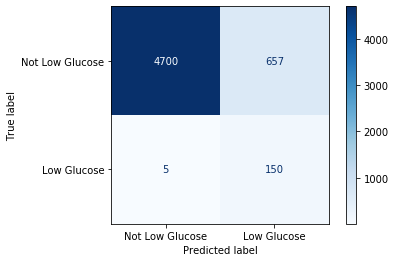

In [134]:
model = LogisticRegression(class_weight='balanced').fit(train_x, train_y)

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


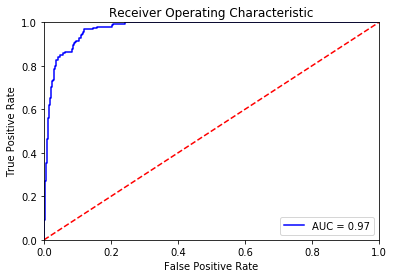

In [135]:
probs = model.predict_proba(test_x)
preds = probs[:,1]

fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

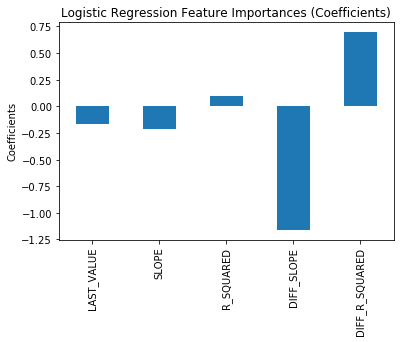

In [136]:
feature_names = FEATURE_COLS
importances = model.coef_[0]
# plot feature importance
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()

forest_importances.plot.bar(ax=ax)
ax.set_title("Logistic Regression Feature Importances (Coefficients)")
ax.set_ylabel("Coefficients")

plt.show()

In [137]:
probs = model.predict_proba(glucose_stats_df[FEATURE_COLS])
preds = probs[:,1]

glucose_stats_df['LOG_REG_PREDICTION'] = np.where(preds > 0.5, 1, 0)
glucose_stats_df.head()

,INDEX,CURRENT_VALUE,LAST_VALUE,SLOPE,R_SQUARED,SLOPE_SECOND_HALF,C0,C1,C2,GLUCOSE_MEAN,...,CURVATURE_MIN,CURVATURE_MIN_GLUCOSE,CURVATURE_MIN_MINUTE,EXTRAPOLATED_VALUE_FIRST_ORDER,EXTRAPOLATED_VALUE_SECOND_ORDER,IS_LOW,LOOK_AHEAD_VALUE,LOG_REG_PREDICTION,RANDOM_FOREST_PREDICTION,LIN_REG_PREDICTION
0,10,84,105,1.10,0.88,"(0.1, 0.75)",-0.045000,2.227857,81.964286,99.50,...,-4.75,108,15.0,129.83,99.08,0,88,0,0,100.572108
1,14,108,90,-1.03,0.89,"(-0.5, 0.89)",-0.007143,-0.855714,110.500000,98.17,...,-4.75,109,5.0,69.72,64.84,0,95,0,0,83.194305
2,18,88,100,0.40,0.91,"(0.6, 0.96)",0.013571,0.060714,87.464286,91.33,...,-1.00,97,25.0,102.33,111.61,0,95,0,0,97.083173
3,22,95,92,-0.10,0.15,"(-0.5, 0.99)",-0.031429,0.682857,95.000000,96.33,...,-2.50,100,10.0,93.50,72.03,0,95,0,0,85.034078
4,26,95,88,-0.06,0.10,"(0.1, 0.06)",0.010714,-0.325000,94.607143,93.00,...,-3.50,92,25.0,91.43,98.75,0,85,0,0,84.119030


In [138]:
true_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['LOG_REG_PREDICTION'] == 1) ]
true_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['LOG_REG_PREDICTION'] == 0) ]
false_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['LOG_REG_PREDICTION'] == 1) ]
false_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['LOG_REG_PREDICTION'] == 0) ]

print('# True Positives: {}'.format(true_positive.shape[0]))
print('# True Negatives: {}'.format(true_negative.shape[0]))
print('# False Positives: {}'.format(false_positive.shape[0]))
print('# False Negatives: {}'.format(false_negative.shape[0]))

# True Positives: 474
# True Negatives: 15760
# False Positives: 2109
# False Negatives: 28


Text(0.5, 0, 'True Glucose')

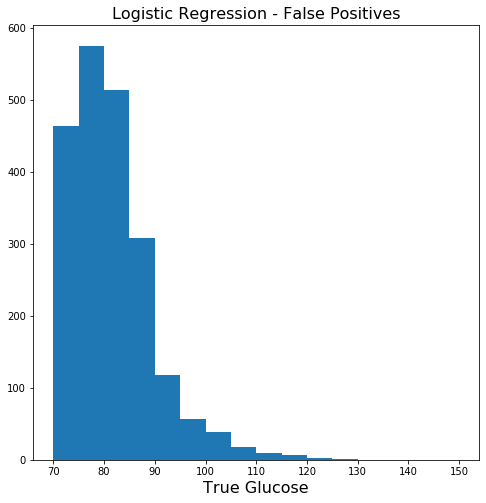

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

plt.title('Logistic Regression - False Positives', fontsize=16)


ax.hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150])
ax.set_xlabel('True Glucose', fontsize=16)



In [144]:
print(false_positive[['INDEX', 'LOOK_AHEAD_VALUE'] + FEATURE_COLS].head(10))

     INDEX  LOOK_AHEAD_VALUE  LAST_VALUE  SLOPE  R_SQUARED  DIFF_SLOPE  \
13      71                95          90  -2.65       0.92       -0.80   
31     143                83          85  -1.20       0.97        0.16   
32     147                78          81  -0.73       0.86        0.20   
33     151                74          76  -0.21       0.93        0.06   
65     286                74          84  -0.70       0.97        0.16   
75     333                87          89  -1.15       0.95       -0.32   
89     389                77          74  -2.77       0.94       -0.16   
90     393                90          75   0.22       0.66       -0.10   
93     410                78          81   0.88       0.94       -0.24   
141    608                75          82  -1.19       0.97       -0.30   

     DIFF_R_SQUARED  
13             0.44  
31             0.11  
32             0.13  
33             0.22  
65             0.57  
75             0.80  
89             0.01  
90       

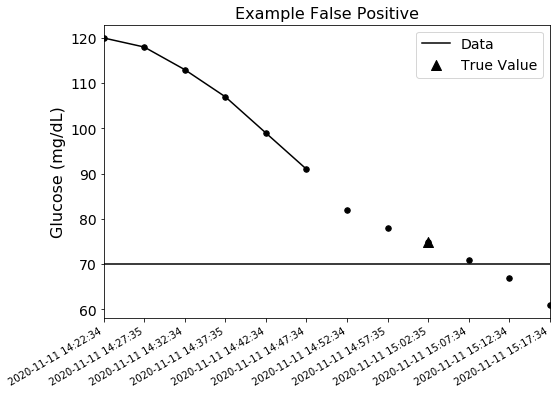

In [145]:
import matplotlib.dates as mdates
import matplotlib.ticker

INDEX = 608
NUM_POINTS = 12
NUM_DATA = 6
TO_LOW = 3

example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(example_dates, example_values, color='k', s=30)
ax.plot(example_dates[:NUM_DATA], example_values[:NUM_DATA], color='k', ls='-', label='Data')

ax.scatter(example_dates[NUM_DATA+TO_LOW-1], example_values[NUM_DATA+TO_LOW-1], marker='^', facecolor='k', s=100, label='True Value')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Example False Positive', fontsize=16)
fig.autofmt_xdate()


## Random Forest

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      5357
           1       0.25      0.90      0.39       155

    accuracy                           0.92      5512
   macro avg       0.62      0.91      0.67      5512
weighted avg       0.98      0.92      0.94      5512



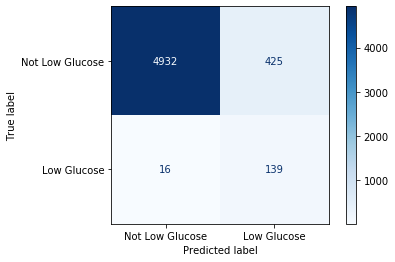

In [146]:
model = RandomForestClassifier(max_depth=5, max_features='auto', criterion='gini', class_weight='balanced').fit(train_x, train_y)

preds = model.predict(test_x)

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

print(classification_report(test_y, preds))


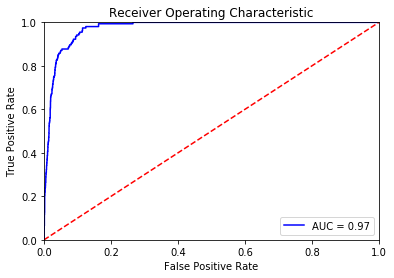

In [147]:
probs = model.predict_proba(test_x)
preds = probs[:,1]

fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

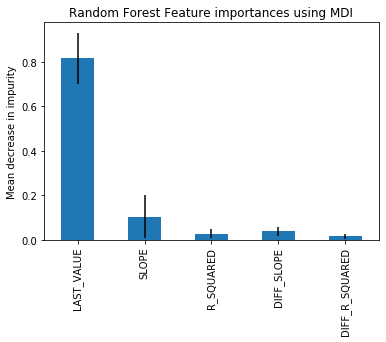

In [148]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = FEATURE_COLS

forest_importances = pd.Series(importances, index=feature_names)

# summarize feature importance
# for i,v in enumerate(importances):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random Forest Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [149]:
preds = model.predict(glucose_stats_df[FEATURE_COLS])

glucose_stats_df['RANDOM_FOREST_PREDICTION'] = preds
glucose_stats_df.head()

,INDEX,CURRENT_VALUE,LAST_VALUE,SLOPE,R_SQUARED,SLOPE_SECOND_HALF,C0,C1,C2,GLUCOSE_MEAN,...,CURVATURE_MIN,CURVATURE_MIN_GLUCOSE,CURVATURE_MIN_MINUTE,EXTRAPOLATED_VALUE_FIRST_ORDER,EXTRAPOLATED_VALUE_SECOND_ORDER,IS_LOW,LOOK_AHEAD_VALUE,LOG_REG_PREDICTION,RANDOM_FOREST_PREDICTION,LIN_REG_PREDICTION
0,10,84,105,1.10,0.88,"(0.1, 0.75)",-0.045000,2.227857,81.964286,99.50,...,-4.75,108,15.0,129.83,99.08,0,88,0,0,100.572108
1,14,108,90,-1.03,0.89,"(-0.5, 0.89)",-0.007143,-0.855714,110.500000,98.17,...,-4.75,109,5.0,69.72,64.84,0,95,0,0,83.194305
2,18,88,100,0.40,0.91,"(0.6, 0.96)",0.013571,0.060714,87.464286,91.33,...,-1.00,97,25.0,102.33,111.61,0,95,0,0,97.083173
3,22,95,92,-0.10,0.15,"(-0.5, 0.99)",-0.031429,0.682857,95.000000,96.33,...,-2.50,100,10.0,93.50,72.03,0,95,0,0,85.034078
4,26,95,88,-0.06,0.10,"(0.1, 0.06)",0.010714,-0.325000,94.607143,93.00,...,-3.50,92,25.0,91.43,98.75,0,85,0,0,84.119030


In [150]:
true_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['RANDOM_FOREST_PREDICTION'] == 1) ]
true_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['RANDOM_FOREST_PREDICTION'] == 0) ]
false_positive = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 0) & (glucose_stats_df['RANDOM_FOREST_PREDICTION'] == 1) ]
false_negative = glucose_stats_df.loc[ (glucose_stats_df['IS_LOW'] == 1) & (glucose_stats_df['RANDOM_FOREST_PREDICTION'] == 0) ]

print('# True Positives: {}'.format(true_positive.shape[0]))
print('# True Negatives: {}'.format(true_negative.shape[0]))
print('# False Positives: {}'.format(false_positive.shape[0]))
print('# False Negatives: {}'.format(false_negative.shape[0]))

# True Positives: 472
# True Negatives: 16518
# False Positives: 1351
# False Negatives: 30


Text(92, 400, '92% of false positives have\ntrue glucose values below 90 mg/dL')

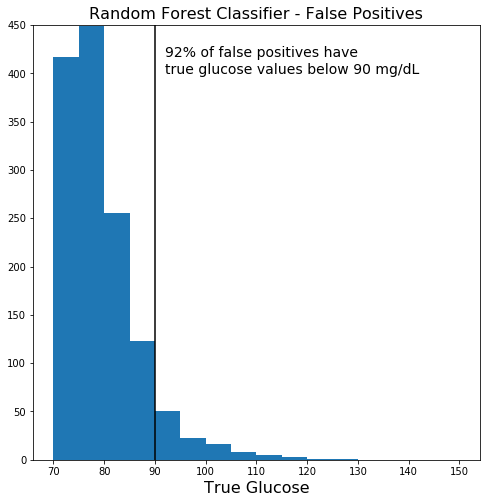

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

plt.title('Random Forest Classifier - False Positives', fontsize=16)

counts = plt.hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150], color='k')
val = np.sum(counts[0][:4]) / np.sum(counts[0]) * 100

ax.hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150])
ax.set_xlabel('True Glucose', fontsize=16)
ax.vlines(90, 0, 450)
ax.set_ylim([0, 450])
ax.text(92, 400, '{:.0f}% of false positives have\ntrue glucose values below 90 mg/dL'.format(val), fontsize=14)


In [152]:
print(false_positive[['INDEX', 'LOOK_AHEAD_VALUE'] + FEATURE_COLS].head(10))

     INDEX  LOOK_AHEAD_VALUE  LAST_VALUE  SLOPE  R_SQUARED  DIFF_SLOPE  \
31     143                83          85  -1.20       0.97        0.16   
32     147                78          81  -0.73       0.86        0.20   
33     151                74          76  -0.21       0.93        0.06   
65     286                74          84  -0.70       0.97        0.16   
89     389                77          74  -2.77       0.94       -0.16   
90     393                90          75   0.22       0.66       -0.10   
141    608                75          82  -1.19       0.97       -0.30   
157    681                86          72  -0.37       0.21       -0.76   
203    865                78          85  -1.17       0.99       -0.10   
228    992                87          78   0.87       0.51        0.94   

     DIFF_R_SQUARED  
31             0.11  
32             0.13  
33             0.22  
65             0.57  
89             0.01  
90             0.13  
141            0.91  
157      

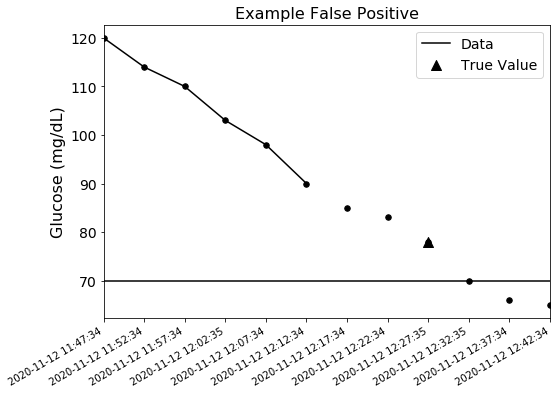

In [153]:
import matplotlib.dates as mdates
import matplotlib.ticker

INDEX = 865
NUM_POINTS = 12
NUM_DATA = 6
TO_LOW = 3

example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values
# predicted_value = glucose_stats_df.loc[glucose_stats_df['INDEX'] == INDEX]['LIN_REG_PREDICTION']



fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(example_dates, example_values, color='k', s=30)
ax.plot(example_dates[:NUM_DATA], example_values[:NUM_DATA], color='k', ls='-', label='Data')

ax.scatter(example_dates[NUM_DATA+TO_LOW-1], example_values[NUM_DATA+TO_LOW-1], marker='^', facecolor='k', s=100, label='True Value')
# ax.scatter(example_dates[NUM_DATA+TO_LOW-1], predicted_value, marker='^', facecolor='w', edgecolor='k', s=100, label='Predicted Value')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Example False Positive', fontsize=16)
fig.autofmt_xdate()


### Hyperparameter tuning

In [154]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


tuned_parameters = [{'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy'], 'max_features': ["auto", "log2"]}]

scores = ['f1', 'precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    ### Default is 5-fold cross validation

    clf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'), tuned_parameters, scoring='%s_macro' % score
    )

    clf.fit(train_x, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_x)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2'}

Grid scores on development set:

0.681 (+/-0.019) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
0.682 (+/-0.028) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
0.770 (+/-0.025) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto'}
0.774 (+/-0.037) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
0.745 (+/-0.035) for {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto'}
0.761 (+/-0.025) for {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2'}
0.671 (+/-0.020) for {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'}
0.671 (+/-0.026) for {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2'}
0.775 (+/-0.028) for {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}
0.780 (+/-0.026) for {'criterion': 'entropy', 'max_depth':

## Random Forest - SMOTE Oversample

In [155]:
train, test = train_test_split(glucose_stats_df[FEATURE_COLS + PREDICT_COL], test_size=0.3, random_state=seed)
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      5357
           1       0.25      0.92      0.40       155

    accuracy                           0.92      5512
   macro avg       0.63      0.92      0.68      5512
weighted avg       0.98      0.92      0.94      5512



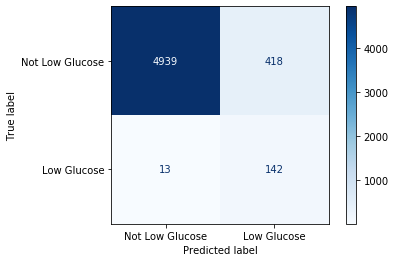

In [156]:
model = RandomForestClassifier(criterion= 'gini', max_depth= 5, max_features= 'auto', class_weight='balanced').fit(train_x, train_y)

preds = model.predict(test_x)

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)

print(classification_report(test_y, preds))


In [236]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


tuned_parameters = [{'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy'], 'max_features': ["auto", "log2"]}]

scores = ['f1', 'precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    ### Default is 5-fold cross validation

    clf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'), tuned_parameters, scoring='%s_macro' % score
    )

    clf.fit(train_x, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_y, clf.predict(test_x)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}

Grid scores on development set:

0.684 (+/-0.028) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
0.684 (+/-0.028) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
0.775 (+/-0.028) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto'}
0.768 (+/-0.035) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
0.753 (+/-0.015) for {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto'}
0.757 (+/-0.058) for {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2'}
0.673 (+/-0.025) for {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'}
0.675 (+/-0.019) for {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2'}
0.778 (+/-0.028) for {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}
0.775 (+/-0.040) for {'criterion': 'entropy', 'max_depth':

# Linear Regression

In [160]:
n_lows = glucose_stats_df[glucose_stats_df['IS_LOW'] == 1].shape[0]

undersampled_df = glucose_stats_df[glucose_stats_df['IS_LOW'] == 0].sample(n=n_lows)

undersampled_df = undersampled_df.append(glucose_stats_df[glucose_stats_df['IS_LOW'] == 1])
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1004 entries, 9307 to 18134
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   INDEX                            1004 non-null   int64  
 1   CURRENT_VALUE                    1004 non-null   int64  
 2   LAST_VALUE                       1004 non-null   int64  
 3   SLOPE                            1004 non-null   float64
 4   R_SQUARED                        1004 non-null   float64
 5   SLOPE_SECOND_HALF                1004 non-null   object 
 6   C0                               1004 non-null   float64
 7   C1                               1004 non-null   float64
 8   C2                               1004 non-null   float64
 9   GLUCOSE_MEAN                     1004 non-null   float64
 10  GLUCOSE_MEDIAN                   1004 non-null   float64
 11  MEAN_TO_MEDIAN                   1004 non-null   float64
 12  GLUCOSE_STDDEV  

In [161]:
PREDICT_COL = ['LOOK_AHEAD_VALUE']


train, test = train_test_split(undersampled_df[FEATURE_COLS + PREDICT_COL], test_size=0.3, random_state=seed)
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1]


In [162]:
model = LinearRegression().fit(train_x, train_y)


In [168]:
print(model.intercept_)
print(model.coef_)
preds = model.predict(test_x)

-9.476194511497908
[ 1.04499733  2.47635834  0.87996313  5.0015151  -0.3855963 ]


In [169]:
r_squared = model.score(train_x, train_y)

In [170]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

regr = sm.OLS(train_y, train_x)
fit = regr.fit()

print(fit)

st, data, ss2 = summary_table(fit, alpha=0.05)



print(train_y)
print(st)

1139      69
13223    148
10888     56
10312    100
16096     69
        ... 
13462    124
13380    101
12205     69
15842     76
3103     150
Name: LOOK_AHEAD_VALUE, Length: 702, dtype: int64
       Obs    Dep Var  Predicted    Std Error    Mean ci    Mean ci Predict ci Predict ci   Residual  Std Error    Student     Cook's
           Population      Value Mean Predict    95% low    95% upp    95% low    95% upp              Residual   Residual          D
-------------------------------------------------------------------------------------------------------------------------------------
         1     69.000     70.022        0.536     68.969     71.074     51.249     88.794     -1.022      9.531     -0.107      0.000
         2    148.000    136.613        0.536    135.561    137.665    117.841    155.385     11.387      9.531      1.195      0.001
         3     56.000     58.909        0.586     57.758     60.060     40.131     77.687     -2.909      9.528     -0.305      0.000
   

[0, 350, 0, 350]

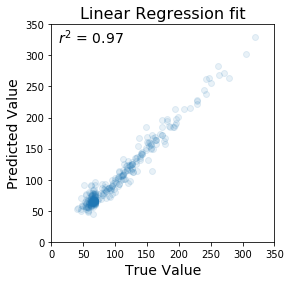

In [171]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

plt.scatter(test_y, preds, alpha=0.1)
plt.xlabel('True Value', fontsize=14)
plt.ylabel('Predicted Value', fontsize=14)
plt.text(10, 320, '$r^2$ = {:.2f}'.format(r_squared), fontsize=14)
plt.title('Linear Regression fit', fontsize=16)
plt.axis([0,350,0,350])

In [172]:
N = len(test_x)
p = len(FEATURE_COLS) + 1  # plus one because LinearRegression adds an intercept term

X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = test_x.values


y_hat = model.predict(test_x)


residuals = test_y.values - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

y_hat = model.predict(glucose_stats_df[FEATURE_COLS])
glucose_stats_df['LIN_REG_PREDICTION'] = y_hat

SE(beta_hat[0]): 2.2160969012808596
SE(beta_hat[1]): 0.012360531944426573
SE(beta_hat[2]): 0.6027354862449381
SE(beta_hat[3]): 1.9153101902478953
SE(beta_hat[4]): 1.3107672209247843
SE(beta_hat[5]): 1.798440607790329


In [173]:
true_positive = glucose_stats_df.loc[ (glucose_stats_df['LOOK_AHEAD_VALUE'] < 70 ) & (glucose_stats_df['LIN_REG_PREDICTION'] < 70) ]
true_negative = glucose_stats_df.loc[ (glucose_stats_df['LOOK_AHEAD_VALUE'] >= 70) & (glucose_stats_df['LIN_REG_PREDICTION'] >= 70) ]
false_positive = glucose_stats_df.loc[ (glucose_stats_df['LOOK_AHEAD_VALUE'] >= 70) & (glucose_stats_df['LIN_REG_PREDICTION'] < 70) ]
false_negative = glucose_stats_df.loc[ (glucose_stats_df['LOOK_AHEAD_VALUE'] < 70) & (glucose_stats_df['LIN_REG_PREDICTION'] >= 70) ]

print('# True Positives: {}'.format(true_positive.shape[0]))
print('# True Negatives: {}'.format(true_negative.shape[0]))
print('# False Positives: {}'.format(false_positive.shape[0]))
print('# False Negatives: {}'.format(false_negative.shape[0]))

# True Positives: 399
# True Negatives: 17308
# False Positives: 561
# False Negatives: 103


Text(92, 275, '98% of false positives have\ntrue glucose values below 90 mg/dL')

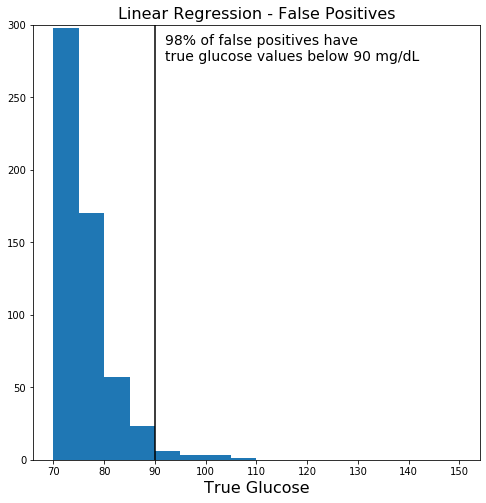

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

plt.title('Linear Regression - False Positives', fontsize=16)

counts = plt.hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150], color='k')
val = np.sum(counts[0][:4]) / np.sum(counts[0]) * 100

ax.hist(false_positive['LOOK_AHEAD_VALUE'].values, bins=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150])
ax.set_xlabel('True Glucose', fontsize=16)
ax.vlines(90, 0, 300)
ax.set_ylim([0, 300])
ax.text(92, 275, '{:.0f}% of false positives have\ntrue glucose values below 90 mg/dL'.format(val), fontsize=14)


In [181]:
print(false_positive[['INDEX'] + FEATURE_COLS].head())

     INDEX  LAST_VALUE  SLOPE  R_SQUARED  DIFF_SLOPE  DIFF_R_SQUARED
89     389          74  -2.77       0.94       -0.16            0.01
90     393          75   0.22       0.66       -0.10            0.13
157    681          72  -0.37       0.21       -0.76            0.59
266   1144          67  -0.87       0.97       -0.08            0.08
353   1531          73   0.46       0.37       -0.74            0.82


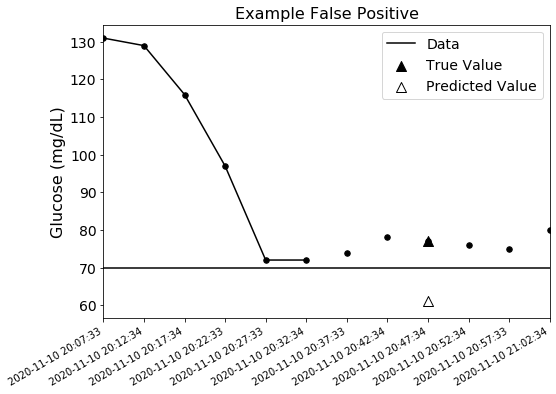

In [182]:
import matplotlib.dates as mdates
import matplotlib.ticker

INDEX = 389
NUM_POINTS = 12
NUM_DATA = 6
TO_LOW = 3

example_dates = glucose_df['Timestamp'].iloc[INDEX:INDEX+NUM_POINTS].values
example_values = glucose_df['Glucose'].iloc[INDEX:INDEX+NUM_POINTS].values
predicted_value = glucose_stats_df.loc[glucose_stats_df['INDEX'] == INDEX]['LIN_REG_PREDICTION']

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(example_dates, example_values, color='k', s=30)
ax.plot(example_dates[:NUM_DATA], example_values[:NUM_DATA], color='k', ls='-', label='Data')

ax.scatter(example_dates[NUM_DATA+TO_LOW-1], example_values[NUM_DATA+TO_LOW-1], marker='^', facecolor='k', s=100, label='True Value')
ax.scatter(example_dates[NUM_DATA+TO_LOW-1], predicted_value, marker='^', facecolor='w', edgecolor='k', s=100, label='Predicted Value')
ax.hlines(70, 0, len(example_dates))
ax.set_xlim([example_dates[0], example_dates[-1]])
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_ylabel('Glucose (mg/dL)', fontsize=16)
ax.legend(fontsize=14)
ax.set_title('Example False Positive', fontsize=16)
fig.autofmt_xdate()
